In [1]:
import sys
from pathlib import Path
import os

def is_google_colab() -> bool:
    if "google.colab" in str(get_ipython()):
        return True
    return False

def clone_repository() -> None:
    !git clone https://github.com/featurestorebook/mlfs-book.git
    %cd mlfs-book

def install_dependencies() -> None:
    !pip install --upgrade uv
    !uv pip install --all-extras --system --requirement pyproject.toml

if is_google_colab():
    clone_repository()
    install_dependencies()
    root_dir = str(Path().absolute())
    print("Google Colab environment")
else:
    root_dir = Path().absolute()
    # Strip ~/notebooks/ccfraud from PYTHON_PATH if notebook started in one of these subdirectories
    if root_dir.parts[-1:] == ('airquality',):
        root_dir = Path(*root_dir.parts[:-1])
    if root_dir.parts[-1:] == ('notebooks',):
        root_dir = Path(*root_dir.parts[:-1])
    root_dir = str(root_dir) 
    print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
from mlfs import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")

Local environment
Added the following directory to the PYTHONPATH: d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book-main
HopsworksSettings initialized!


In [2]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks
from mlfs.airquality import util
import json

import warnings
warnings.filterwarnings("ignore")

In [ ]:
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

secrets = hopsworks.get_secrets_api()
location_str = secrets.get_secret("SENSOR1_LOCATION_JSON").value
location = json.loads(location_str)
country=location['country']
city=location['city']
street=location['street']

2025-11-12 21:00:46,548 INFO: Initializing external client
2025-11-12 21:00:46,549 INFO: Base URL: https://c.app.hopsworks.ai:443


2025-11-12 21:00:48,496 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1298583


In [4]:
air_quality_fg_v1 = fs.get_feature_group(name='air_quality', version=1)
weather_fg_v1 = fs.get_feature_group(name='weather', version=1)

In [5]:
selected_features_v1 = air_quality_fg_v1.select(['pm25', 'date']).join(
    weather_fg_v1.select_features(), on=['city']
)

2025-11-12 21:00:50,737 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [6]:
fv_v1 = fs.get_or_create_feature_view(
    name='air_quality_fv',
    version=1,
    labels=['pm25'],
    query=selected_features_v1,
)

In [7]:
start_date_test_data = "2025-05-01"
# Convert string to datetime object
test_start = datetime.strptime(start_date_test_data, "%Y-%m-%d")

In [8]:
X_train_v1, X_test_v1, y_train_v1, y_test_v1 = fv_v1.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.11s) 


In [10]:
X_train_v1

,date,temperature_2m_mean,precipitation_sum,wind_speed_10m_max,wind_direction_10m_dominant
0,2017-10-04 00:00:00+00:00,10.587333,2.900000,22.206486,248.656326
1,2017-10-05 00:00:00+00:00,8.433167,2.600000,16.595179,306.521240
2,2017-10-06 00:00:00+00:00,8.247749,0.500000,23.871555,320.408325
3,2017-10-07 00:00:00+00:00,6.131084,6.300001,14.332341,343.018829
4,2017-10-08 00:00:00+00:00,6.637333,23.200001,28.442278,343.866455
...,...,...,...,...,...
2679,2025-04-26 00:00:00+00:00,4.939417,0.000000,13.752048,326.839844
2680,2025-04-27 00:00:00+00:00,8.479001,0.000000,18.083506,211.242142
2681,2025-04-28 00:00:00+00:00,11.935249,0.100000,25.084663,258.606140
2682,2025-04-29 00:00:00+00:00,11.904000,0.000000,20.170443,301.991791


In [11]:
X_features = X_train_v1.drop(columns=['date'])
X_test_features = X_test_v1.drop(columns=['date'])

In [12]:
y_train_v1

,pm25
0,13.0
1,9.0
2,8.0
3,13.0
4,8.0
...,...
2679,15.0
2680,16.0
2681,27.0
2682,12.0


In [14]:
xgb_v1 = XGBRegressor()
xgb_v1.fit(X_features, y_train_v1)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [15]:
y_pred_v1 = xgb_v1.predict(X_test_features)

In [16]:
mse_v1 = mean_squared_error(y_test_v1.iloc[:,0], y_pred_v1)
r2_v1 = r2_score(y_test_v1.iloc[:,0], y_pred_v1)
print(f"v1 MSE: {mse_v1:.4f}, R²: {r2_v1:.4f}")

v1 MSE: 136.2022, R²: -0.3663


In [17]:
air_quality_fg_v2 = fs.get_feature_group(name='air_quality', version=2)
weather_fg_v2 = fs.get_feature_group(name='weather', version=1)

In [18]:
selected_features_v2 = air_quality_fg_v2.select([
    'pm25', 'pm25_lag_1', 'pm25_lag_2', 'pm25_lag_3', 'date'
]).join(weather_fg_v2.select_features(), on=['city'])

2025-11-12 21:05:17,481 INFO: Using ['temperature_2m_mean', 'precipitation_sum', 'wind_speed_10m_max', 'wind_direction_10m_dominant'] from feature group `weather` as features for the query. To include primary key and event time use `select_all`.


In [19]:
fv_v2 = fs.get_or_create_feature_view(
    name='air_quality_fv_with_lags',
    version=2,
    labels=['pm25'],
    query=selected_features_v2,
)

Feature view created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/1298583/fs/1286215/fv/air_quality_fv_with_lags/version/2


In [20]:
X_train_v2, X_test_v2, y_train_v2, y_test_v2 = fv_v2.train_test_split(
    test_start=test_start
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (2.51s) 


In [21]:
X_features = X_train_v2.drop(columns=['date'])
X_test_features = X_test_v2.drop(columns=['date'])

In [22]:
xgb_v2 = XGBRegressor()
xgb_v2.fit(X_features, y_train_v2)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [23]:
y_pred_v2 = xgb_v2.predict(X_test_features)

mse_v2 = mean_squared_error(y_test_v2.iloc[:,0], y_pred_v2)
r2_v2 = r2_score(y_test_v2.iloc[:,0], y_pred_v2)
print(f"v2 MSE: {mse_v2:.4f}, R²: {r2_v2:.4f}")

v2 MSE: 54.8582, R²: 0.4632


In [24]:
df = y_test_v2
df['predicted_pm25'] = y_pred_v2

In [25]:
df['date'] = X_test_v2['date']
df = df.sort_values(by=['date'])
df.head(5)

,pm25,predicted_pm25,date
2684,18.0,25.687645,2025-05-01 00:00:00+00:00
2685,19.0,19.095495,2025-05-02 00:00:00+00:00
2686,10.0,18.384190,2025-05-03 00:00:00+00:00
2687,8.0,10.303281,2025-05-04 00:00:00+00:00
2688,14.0,8.548008,2025-05-05 00:00:00+00:00


In [26]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "air_quality_model_v2"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

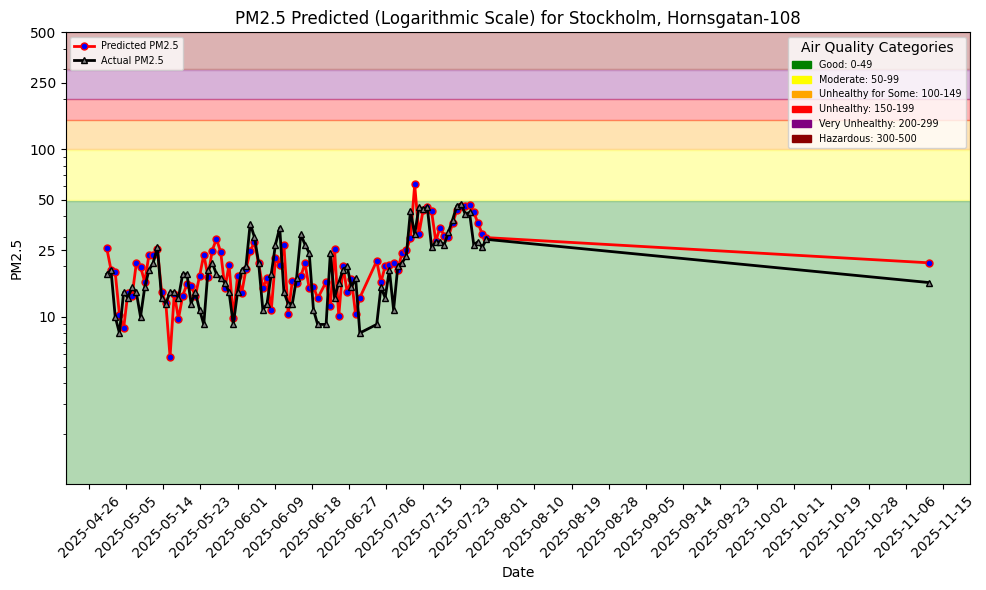

In [27]:
file_path = images_dir + "/pm25_hindcast.png"
plt = util.plot_air_quality_forecast(city, street, df, file_path, hindcast=True) 
plt.show()

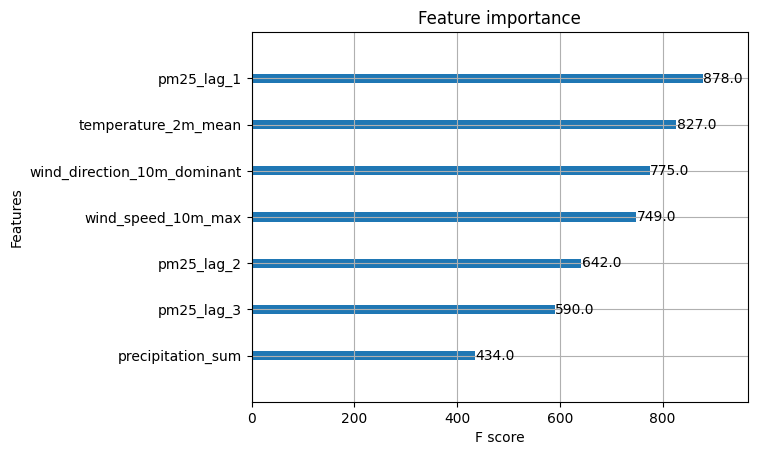

In [28]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_v2)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()

In [29]:
# Saving the XGBoost regressor object as a json file in the model directory
xgb_v2.save_model(model_dir + "/model.json")

In [30]:
res_dict = { 
        "MSE": str(mse_v2),
        "R squared": str(r2_v2),
    }

In [32]:
mr = project.get_model_registry()

# Creating a Python model in the model registry named 'air_quality_xgboost_model'

aq_model = mr.python.create_model(
    name="air_quality_xgboost_model", 
    metrics= res_dict,
    feature_view=fv_v2,
    description="Air Quality (PM2.5) predictor update",
)

# Saving the model artifacts to the 'air_quality_model' directory in the model registry
aq_model.save(model_dir)

  0%|          | 0/6 [00:00<?, ?it/s]

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book-main\notebooks\airquality\air_quali…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book-main\notebooks\airquality\air_quali…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book-main\notebooks\airquality\air_quali…

Uploading d:\KTH\Scalable Machine Learning and Deep Learning\LAB\mlfs-book-main\notebooks\airquality\model_sch…

Model created, explore it at https://c.app.hopsworks.ai:443/p/1298583/models/air_quality_xgboost_model/3


Model(name: 'air_quality_xgboost_model', version: 3)